##### Overview

This notebook imports raw ws3 input data, reformats and monkey-patches the data, and exports Woodstock formatted input data files (which we will use in other DSS notebooks for this case as the input data files). 

# Set up environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import csv
import numpy as np
import time
from functools import partial, wraps
import distance
import operator
import shutil
import os

Define some key model parameters (will get used but defined here up top for convenience).

In [3]:
period_length = 10
max_age =  1000

Define paths required in the code to read and write

In [4]:
# Input paths
shapefile_path = './data/shp_files/tsa17.shp/stands selection.shp'

# Output paths
stands_csv_path = './data/stands.csv'
curve_points_table_csv_path = './data/curve_points_table.csv'

yldmerged_csv_path = './data/yldmerged.csv'

woodstock_model_files_lan_path = './data/woodstock_model_files_ecotrust/ecotrust.lan'
woodstock_model_files_are_path = './data/woodstock_model_files_ecotrust/ecotrust.are'
woodstock_model_files_yld_path = './data/woodstock_model_files_ecotrust/ecotrust.yld'
woodstock_model_files_act_path = './data/woodstock_model_files_ecotrust/ecotrust.act'
woodstock_model_files_trn_path = './data/woodstock_model_files_ecotrust/ecotrust.trn'
contributing_area_path = './data/woodstock_model_files_ecotrust/aoi.txt'



# Import and reformat inventory and yield input data

Read forest inventory data into memory (vector polygon GIS data layer with attribute table, in ESRI Shapefile format). This dataset represents timber supply area (TSA) in British Columbia. We monkey-patch the inventory data here to make it line up nicely with what we need downstream as input for the ws3 model (i.e., changes we make here to the in-memory dataset are not saved to the original dataset on disk). Most of what we are doing here is setting up the _theme_ columns in the attribute table, which should help newer ws3 users make the connection between input data and the landscape themes in ws3 model further down.

In [5]:
stands_org = gpd.read_file(shapefile_path)
stands_org

,theme0,thlb,au,ldspp,age2015,shape_area,geometry
0,tsa17,0,265,Subalpine fir,284,0.000003,"POLYGON ((1416257.318 871547.805, 1416257.967 ..."
1,tsa17,0,265,Subalpine fir,264,0.000003,"POLYGON ((1417800.143 870740.411, 1417776.342 ..."
2,tsa17,1,265,Subalpine fir,284,0.000006,"POLYGON ((1417153.989 871667.519, 1417152.250 ..."
3,tsa17,1,265,Subalpine fir,284,0.000031,"POLYGON ((1417064.217 871672.906, 1417061.179 ..."
4,tsa17,0,265,Subalpine fir,284,0.000005,"POLYGON ((1416257.318 871547.805, 1416236.324 ..."
...,...,...,...,...,...,...,...
1617,tsa17,1,317,White spruce,284,0.000041,"POLYGON ((1419801.287 875363.621, 1419817.382 ..."
1618,tsa17,1,265,Subalpine fir,224,0.000021,"POLYGON ((1419002.453 875670.895, 1419021.639 ..."
1619,tsa17,1,306,Spruce,284,0.000114,"POLYGON ((1418965.559 875961.168, 1418983.000 ..."
1620,tsa17,0,265,Subalpine fir,224,0.000023,"POLYGON ((1419594.851 873878.054, 1419639.287 ..."


In [6]:
stands_org['forest_type'] = stands_org.apply(
    lambda row: 1 if row['age2015'] > (60 + 10) else 2,
    axis=1
)
stands_org

,theme0,thlb,au,ldspp,age2015,shape_area,geometry,forest_type
0,tsa17,0,265,Subalpine fir,284,0.000003,"POLYGON ((1416257.318 871547.805, 1416257.967 ...",1
1,tsa17,0,265,Subalpine fir,264,0.000003,"POLYGON ((1417800.143 870740.411, 1417776.342 ...",1
2,tsa17,1,265,Subalpine fir,284,0.000006,"POLYGON ((1417153.989 871667.519, 1417152.250 ...",1
3,tsa17,1,265,Subalpine fir,284,0.000031,"POLYGON ((1417064.217 871672.906, 1417061.179 ...",1
4,tsa17,0,265,Subalpine fir,284,0.000005,"POLYGON ((1416257.318 871547.805, 1416236.324 ...",1
...,...,...,...,...,...,...,...,...
1617,tsa17,1,317,White spruce,284,0.000041,"POLYGON ((1419801.287 875363.621, 1419817.382 ...",1
1618,tsa17,1,265,Subalpine fir,224,0.000021,"POLYGON ((1419002.453 875670.895, 1419021.639 ...",1
1619,tsa17,1,306,Spruce,284,0.000114,"POLYGON ((1418965.559 875961.168, 1418983.000 ...",1
1620,tsa17,0,265,Subalpine fir,224,0.000023,"POLYGON ((1419594.851 873878.054, 1419639.287 ...",1


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [7]:
columns_to_keep = ['theme0', 'thlb', 'au', 'ldspp', 'age2015', 'shape_area', 'geometry','forest_type']
stands = stands_org[columns_to_keep].copy()
# stands['theme0'] = 'tsa01'
columns = ['theme0'] + \
          [col for col in stands.columns if col not in ['theme0', 'forest_type']]  # Exclude these two
columns.insert(4, 'forest_type')  # Insert 'primary_forest' at the 4th position
stands = stands[columns]  # Apply new order

In [8]:
stands

,theme0,thlb,au,ldspp,forest_type,age2015,shape_area,geometry
0,tsa17,0,265,Subalpine fir,1,284,0.000003,"POLYGON ((1416257.318 871547.805, 1416257.967 ..."
1,tsa17,0,265,Subalpine fir,1,264,0.000003,"POLYGON ((1417800.143 870740.411, 1417776.342 ..."
2,tsa17,1,265,Subalpine fir,1,284,0.000006,"POLYGON ((1417153.989 871667.519, 1417152.250 ..."
3,tsa17,1,265,Subalpine fir,1,284,0.000031,"POLYGON ((1417064.217 871672.906, 1417061.179 ..."
4,tsa17,0,265,Subalpine fir,1,284,0.000005,"POLYGON ((1416257.318 871547.805, 1416236.324 ..."
...,...,...,...,...,...,...,...,...
1617,tsa17,1,317,White spruce,1,284,0.000041,"POLYGON ((1419801.287 875363.621, 1419817.382 ..."
1618,tsa17,1,265,Subalpine fir,1,224,0.000021,"POLYGON ((1419002.453 875670.895, 1419021.639 ..."
1619,tsa17,1,306,Spruce,1,284,0.000114,"POLYGON ((1418965.559 875961.168, 1418983.000 ..."
1620,tsa17,0,265,Subalpine fir,1,224,0.000023,"POLYGON ((1419594.851 873878.054, 1419639.287 ..."


In [9]:
stands = stands.rename(columns={'thlb': 'theme1', 'au': 'theme2', 'ldspp': 'theme3', 'forest_type': 'theme5', 'age2015': 'age', 'shape_area': 'area' })

In [10]:
def ensure_missing_values(df):
    new_rows = []
    for value in df["theme2"].unique():
        # Filter rows where theme1 == 1 and theme2 matches the current value
        subset = df[(df["theme2"] == value) & (df["theme1"] == 1)]
        
        if subset.empty:
            continue  # Skip if no rows with theme1 == 1 for this theme2
        
        possible_values = {1, 2}
        existing_values = set(subset["theme5"])
        missing_values = possible_values - existing_values
        
        for missing_value in missing_values:
            # Use values from the first row in the subset as defaults
            default_theme0 = subset["theme0"].iloc[0]
            default_theme3 = subset["theme3"].iloc[0]
            default_theme1 = subset["theme1"].iloc[0]
            default_theme4 = subset["theme4"].iloc[0]
            
            new_row = {
                "theme0": default_theme0,
                "theme1": default_theme1,
                "theme2": value,
                "theme3": default_theme3,
                "theme4": default_theme4,
                "theme5": missing_value,
                "age": 0,  # Default or placeholder value
                "area": 1,  # Default or placeholder value
            }
            new_rows.append(new_row)
    
    # Append new rows to the DataFrame
    df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
    return df

In [11]:
stands['area'] = stands.geometry.area * 0.0001
# This code changes the type of "theme2" into integer
stands['theme2'] = stands['theme2'].astype(int)
# stands = ensure_missing_values(stands)
stands.insert(4, 'theme4', stands['theme2'])
stands

,theme0,theme1,theme2,theme3,theme4,theme5,age,area,geometry
0,tsa17,0,265,Subalpine fir,265,1,284,2.415193,"POLYGON ((1416257.318 871547.805, 1416257.967 ..."
1,tsa17,0,265,Subalpine fir,265,1,264,2.549479,"POLYGON ((1417800.143 870740.411, 1417776.342 ..."
2,tsa17,1,265,Subalpine fir,265,1,284,4.469771,"POLYGON ((1417153.989 871667.519, 1417152.250 ..."
3,tsa17,1,265,Subalpine fir,265,1,284,22.997008,"POLYGON ((1417064.217 871672.906, 1417061.179 ..."
4,tsa17,0,265,Subalpine fir,265,1,284,3.705852,"POLYGON ((1416257.318 871547.805, 1416236.324 ..."
...,...,...,...,...,...,...,...,...,...
1617,tsa17,1,317,White spruce,317,1,284,30.852752,"POLYGON ((1419801.287 875363.621, 1419817.382 ..."
1618,tsa17,1,265,Subalpine fir,265,1,224,15.450104,"POLYGON ((1419002.453 875670.895, 1419021.639 ..."
1619,tsa17,1,306,Spruce,306,1,284,85.410246,"POLYGON ((1418965.559 875961.168, 1418983.000 ..."
1620,tsa17,0,265,Subalpine fir,265,1,224,17.108374,"POLYGON ((1419594.851 873878.054, 1419639.287 ..."


In [12]:
aoi_contributing_areas = stands[stands['theme1'] == 1]['area'].sum()


Read yield data from a CSV file and recast AU column data type to integer.

In [13]:
# Reading yld table and changing AU column type into integer
yld = pd.read_csv('./data/yld.csv')
yld['AU'] = yld['AU'].astype(int)
yld

,Yieldscode,THLB,AU,LDSPP,SPCode,Wdks,X0,X10,X20,X30,...,X260,X270,X280,X290,X300,X310,X320,X330,X340,X350
0,*Y,?,1,Aspen,AAVOL,1,0.0,0.0,1.2,5.9,...,264.3,265.5,266.7,267.9,269.0,269.5,269.5,269.5,269.4,269.4
1,*Y,?,2,Balsam fir,BFVOL,1,0.0,0.0,0.0,0.0,...,169.0,169.1,169.1,169.2,169.2,169.3,169.1,168.8,168.5,168.2
2,*Y,?,3,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,...,426.9,427.9,428.8,429.6,430.4,431.2,431.4,431.4,431.4,431.4
3,*Y,?,9,Hemlock,HEVOL,1,0.0,0.0,0.0,0.1,...,354.6,356.0,357.3,358.4,358.9,359.2,358.9,357.9,356.9,355.7
4,*Y,?,9,Mountain hemlock,MHVOL,1,0.0,0.0,0.0,0.1,...,354.6,356.0,357.3,358.4,358.9,359.2,358.9,357.9,356.9,355.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,*Y,?,1191,Lodgepole pine,LPVOL,1,0.0,0.0,0.0,0.0,...,31.5,31.6,31.8,31.9,32.0,32.1,32.2,32.2,32.2,32.2
528,*Y,?,1192,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,19.1,19.0,18.9,18.8,19.1,19.4,19.3,19.2,19.2,19.2
529,*Y,?,1196,Poplar,POVOL,1,0.0,0.0,0.0,0.0,...,11.0,11.1,11.2,11.3,11.3,11.4,11.5,11.5,11.5,11.5
530,*Y,?,1202,Lodgepole pine,LPVOL,1,0.0,0.0,0.0,0.0,...,35.4,35.6,35.8,36.0,36.3,36.5,36.6,36.7,36.7,36.7


Create analysis unit (AU) dataframe from stands dataframe data.

In [14]:
# Creating AU table from stands table and renaming the column to AU. The AU table is then joined with yld table.
AU = pd.DataFrame(stands['theme2']).drop_duplicates()
AU.rename(columns = {'theme2':'AU'},inplace=True)

In [15]:
# Inner joining AU and yld tables. The results of the code will be a yield table (yldmerged) that has AU column.
yldmerged = pd.merge(AU, yld, on=['AU'], how='inner')

In [16]:
yldmerged

,AU,Yieldscode,THLB,LDSPP,SPCode,Wdks,X0,X10,X20,X30,...,X260,X270,X280,X290,X300,X310,X320,X330,X340,X350
0,265,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,...,222.1,222.2,222.3,222.5,222.6,222.8,222.9,222.9,222.8,222.7
1,387,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,335.9,334.2,332.6,331.0,329.6,328.3,327.1,326.5,326.3,326.2
2,335,*Y,?,Aspen,AAVOL,1,0.0,0.0,0.0,1.5,...,265.9,265.8,265.7,265.7,265.6,265.5,265.5,265.5,265.5,265.5
3,344,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,...,329.1,328.0,326.9,325.9,325.1,324.2,323.5,323.0,322.6,322.3
4,306,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,277.6,276.8,276.0,275.3,274.7,274.2,273.6,273.3,273.1,273.0
5,365,*Y,?,Western hemlock,WHVOL,1,0.0,0.0,0.0,0.0,...,475.3,475.6,475.9,476.1,476.3,476.6,476.5,476.1,475.5,475.1
6,388,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.2,...,481.0,478.1,475.3,472.7,470.3,467.9,466.2,465.7,465.6,465.5
7,1085,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,53.4,53.5,53.6,53.9,55.3,58.9,58.9,59.1,59.1,59.0
8,400,*Y,?,White spruce,WSVOL,1,0.0,0.0,0.2,0.7,...,481.4,478.3,475.3,472.5,469.8,467.3,465.6,465.1,465.1,465.0
9,307,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.1,...,433.9,432.6,431.4,430.3,429.2,428.2,427.5,427.2,427.1,427.0


Import CANFI tree species lookup table (associates tree species names with integer numerical values, which we use as theme data values in the ws3 model), and insert species code values into the yield curve dataframe.

In [17]:
# Getting names and codes of canfi_species. This table will be used to add canfi_species column into yldmerged
canf = pd.read_csv('data/canfi_species_revised.csv')
canf = canf[['name','canfi_species']].set_index('name')

Burn CANFI species codes into stand and yield data tables.

In [18]:
yldmerged['canfi_species'] = yldmerged.apply(lambda row: canf.loc[row['LDSPP'], 'canfi_species'], axis=1)

In [19]:
# replacing leading species names with their codes
for index, row in stands.iterrows():
    stands.at[index,'theme6'] = canf.loc[row['theme3'],'canfi_species']
stands['theme3'] = stands['theme6']
# stands = stands.drop('theme6',axis=1)
# stands['theme4'] = stands['theme2']
stands['theme3'] = stands['theme3'] .astype(int)

In [20]:
stands

,theme0,theme1,theme2,theme3,theme4,theme5,age,area,geometry,theme6
0,tsa17,0,265,304,265,1,284,2.415193,"POLYGON ((1416257.318 871547.805, 1416257.967 ...",304.0
1,tsa17,0,265,304,265,1,264,2.549479,"POLYGON ((1417800.143 870740.411, 1417776.342 ...",304.0
2,tsa17,1,265,304,265,1,284,4.469771,"POLYGON ((1417153.989 871667.519, 1417152.250 ...",304.0
3,tsa17,1,265,304,265,1,284,22.997008,"POLYGON ((1417064.217 871672.906, 1417061.179 ...",304.0
4,tsa17,0,265,304,265,1,284,3.705852,"POLYGON ((1416257.318 871547.805, 1416236.324 ...",304.0
...,...,...,...,...,...,...,...,...,...,...
1617,tsa17,1,317,105,317,1,284,30.852752,"POLYGON ((1419801.287 875363.621, 1419817.382 ...",105.0
1618,tsa17,1,265,304,265,1,224,15.450104,"POLYGON ((1419002.453 875670.895, 1419021.639 ...",304.0
1619,tsa17,1,306,100,306,1,284,85.410246,"POLYGON ((1418965.559 875961.168, 1418983.000 ...",100.0
1620,tsa17,0,265,304,265,1,224,17.108374,"POLYGON ((1419594.851 873878.054, 1419639.287 ...",304.0


In [21]:
curve_points_table = yldmerged
# Adding 'curve_id' and 'canfi_species' columns to curve_points_table
curve_points_table ['curve_id'] = curve_points_table ['AU']
curve_points_table ['canfi_species'] = yldmerged ['canfi_species'].astype(int)

In [22]:
curve_points_table.head(5)

,AU,Yieldscode,THLB,LDSPP,SPCode,Wdks,X0,X10,X20,X30,...,X280,X290,X300,X310,X320,X330,X340,X350,canfi_species,curve_id
0,265,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,...,222.3,222.5,222.6,222.8,222.9,222.9,222.8,222.7,304,265
1,387,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,332.6,331.0,329.6,328.3,327.1,326.5,326.3,326.2,100,387
2,335,*Y,?,Aspen,AAVOL,1,0.0,0.0,0.0,1.5,...,265.7,265.7,265.6,265.5,265.5,265.5,265.5,265.5,1211,335
3,344,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,...,326.9,325.9,325.1,324.2,323.5,323.0,322.6,322.3,304,344
4,306,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,...,276.0,275.3,274.7,274.2,273.6,273.3,273.1,273.0,100,306


In [23]:
columns_to_index_yld = ['AU']

In [24]:
curve_points_table = curve_points_table.set_index(columns_to_index_yld)

Save reformatted data to CSV files. 

In [25]:
# stands_.to_csv(stands_csv_path, index=False)
# stands_mdf.to_csv(stands_mdf_csv_path, index=False)
# yld_vdyp.to_csv(yld_vdyp_csv_path, index=False)
yldmerged.to_csv(yldmerged_csv_path, header=True, index=False)
stands.to_csv(stands_csv_path, header=True, index=False)
curve_points_table.to_csv(curve_points_table_csv_path, header=True, index=False)

# Export Woodstock-formatted input files 

We can use the new ws3 model instance we just built to export ws3 input files in Woodstock file format. We do this for three reasons. 

The first reason is that it will be simpler and more compact in the actual DSS notebook to instantiate the `ForestModel` object from these Woodstock-formatted files (and also this will provide an opportunity to demonstrate the existance and usage of the Woodstock model import functions that are built into ws3). 

The second reason is that the process of exporting data from a live `ws3.forest.ForestModel` instance to Woodstock-formatted input data files provides some insight into the internal structure and workings of ws3 models (which can be a challenging thing to get started with, particularly if you do not have a lot of experience building and running forest estate models). 

The third reason is that Woodstock file format is designed to be "human readable" (sort of... nobody ever said it would be super easy or super fun). Picking through the exported Woodstock-formatted files might help some people better understand the structure and details of the model we have built. If you have no experience reading Woodstock-formatted model input data files, then this is going to be trickier (unless you pause here and go take an introductory Woodstock training course of sort). Many forest professionals already have familiarity with Woodstock software and its special file format (through having been exposed to this at some point in their career). 

Delete a folder containing previous woodstock files

In [26]:
# Specify the folder to remove
folder_path = "./data/woodstock_model_files_ecotrust"

# Check if the folder exists and remove it
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Removed folder: {folder_path}")
else:
    print(f"Folder does not exist: {folder_path}")


Folder does not exist: ./data/woodstock_model_files_ecotrust


Start by creating a new subdirectory to hold the new Woodstock-formatted data files.

In [27]:
!mkdir data/woodstock_model_files_ecotrust

## LANDSCAPE section

The LANDSCAPE section defines stratification variables (themes) and stratification variable values (basecodes). 

In [28]:
theme_cols=['theme0', # TSA 
            'theme1', # THLB
            'theme2', # AUs
            'theme3', # leading species code
            'theme4',  # yield curve ID
            'theme5',  # forest type
           ]
basecodes = [list(map(lambda x: str(x), stands[tc].unique())) for tc in theme_cols]
basecodes[2] = list(set(basecodes[2] + list(stands['theme2'].astype(str))))
basecodes[3] = list(set(basecodes[3] + list(stands['theme3'].astype(str))))
# basecodes[4] = list(set(basecodes[4] + list((stands['theme2'] * 1000 + 1).astype(str)) + list((stands['theme2'] * 1000 + 2).astype(str))))
basecodes[4] = list(set(basecodes[4] + list(stands['theme4'].astype(str))))
basecodes[5] = list(set(basecodes[5] + list(stands['theme5'].astype(str))))

In [29]:
basecodes[4]

['717',
 '336',
 '711',
 '307',
 '299',
 '257',
 '356',
 '277',
 '348',
 '710',
 '728',
 '681',
 '358',
 '298',
 '1192',
 '265',
 '387',
 '285',
 '276',
 '354',
 '353',
 '266',
 '379',
 '399',
 '366',
 '328',
 '347',
 '690',
 '718',
 '296',
 '312',
 '357',
 '702',
 '317',
 '365',
 '682',
 '735',
 '335',
 '345',
 '733',
 '734',
 '344',
 '318',
 '400',
 '1085',
 '1103',
 '306',
 '388',
 '378']

In [30]:
with open(woodstock_model_files_lan_path, 'w') as file:
    print('*THEME Timber Supply Area (TSA)', file=file)
    # print('tsa01',file=file)
    for basecode in basecodes[0]: print(basecode, file=file)
    print('*THEME Timber Harvesting Land Base (THLB)', file=file)
    for basecode in basecodes[1]: print(basecode, file=file)
    print('*THEME Analysis Unit (AU)', file=file)
    for basecode in basecodes[2]: print(basecode, file=file)
    print('*THEME Leading tree species (CANFI species code)', file=file)
    for basecode in basecodes[3]: print(basecode, file=file)
    print('*THEME Yield curve ID', file=file)
    for basecode in basecodes[4]: print(basecode, file=file)
    print('*THEME Forest Type', file=file)
    for basecode in basecodes[5]: print(basecode, file=file)

## AREAS section

The AREAS section defines the initial forest inventory, in terms of how many hectares of which age class are present in which development type (where a development type is defined as a unique sequence of landscape theme variable values).

In [31]:
gstands = stands.groupby(theme_cols+['age'])

In [32]:
with open(woodstock_model_files_are_path, 'w') as file:
    age_cutoff = 600
    for name, group in gstands:
        dtk, age, area = tuple(map(lambda x: str(x), name[:-1])), int(name[-1]), group['area'].sum()
        print('*A', ' '.join(v for v in dtk), age, round(area, 10), file=file)

## YIELDS section

The YIELDS section defines yield curves (in this example we only track merchantable log volume, but we can use yield curves to track all sorts of other stuff). 

In [33]:
curve_points_table['forest_type'] = 1
new_rows = curve_points_table.copy()
new_rows["forest_type"] += 1

# Combine original and new rows
curve_points_table = pd.concat([curve_points_table, new_rows]).sort_index().reset_index(drop=True)

curve_points_table

,Yieldscode,THLB,LDSPP,SPCode,Wdks,X0,X10,X20,X30,X40,...,X290,X300,X310,X320,X330,X340,X350,canfi_species,curve_id,forest_type
0,*Y,?,Aspen,AAVOL,1,0.0,0.0,0.3,5.1,24.8,...,429.3,429.4,429.5,429.5,429.5,429.5,429.4,1211,257,2
1,*Y,?,Aspen,AAVOL,1,0.0,0.0,0.3,5.1,24.8,...,429.3,429.4,429.5,429.5,429.5,429.5,429.4,1211,257,1
2,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,0.1,...,222.5,222.6,222.8,222.9,222.9,222.8,222.7,304,265,1
3,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.0,0.0,0.1,...,222.5,222.6,222.8,222.9,222.9,222.8,222.7,304,265,2
4,*Y,?,Subalpine fir,SFVOL,1,0.0,0.0,0.1,0.4,7.3,...,498.6,499.0,499.5,499.7,499.6,499.5,499.3,304,266,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,0.0,...,53.9,55.3,58.9,58.9,59.1,59.1,59.0,100,1085,2
94,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,0.0,...,41.7,41.6,42.5,42.4,42.3,42.2,42.2,100,1103,2
95,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,0.0,...,41.7,41.6,42.5,42.4,42.3,42.2,42.2,100,1103,1
96,*Y,?,Spruce,SPVOL,1,0.0,0.0,0.0,0.0,0.0,...,18.8,19.1,19.4,19.3,19.2,19.2,19.2,100,1192,2


In [34]:
with open(woodstock_model_files_yld_path, 'w') as file:
        tot=[]
        swd=[]
        hwd=[]
        for AU, au_row in curve_points_table.iterrows():
            yname = 's%04d' % int(au_row.canfi_species)    
            curve_id = au_row.curve_id
            forest_type = au_row.forest_type
            mask = ('?', '?', str(curve_id), '?', str(curve_id), str(forest_type))
            points = [(x*10, au_row['X%i' % (x*10)]) for x in range(36)]
            c = ws3.core.Curve(yname, points=points, type='a', is_volume=True, xmax=max_age, period_length=period_length)
            print('*Y', ' '.join(v for v in mask), file=file)
            print(yname, '1', ' '.join(str(int(c[x])) for x in range(0, 350, 10)), file=file)
            if yname not in tot:
                tot.append(yname)
            if int(au_row.canfi_species) > 1200:
                if yname not in hwd: hwd.append(yname)
            else:
                if yname not in swd: swd.append(yname)
        print('*YC ? ? ? ? ? ?', file=file)
        print('totvol _SUM(%s)' % ', '.join(map(str, tot)), file=file)
        print('swdvol _SUM(%s)' % ', '.join(map(str, swd)), file=file)
        print('hwdvol _SUM(%s)' % ', '.join(map(str, hwd)), file=file)

(0.0, 300.0)

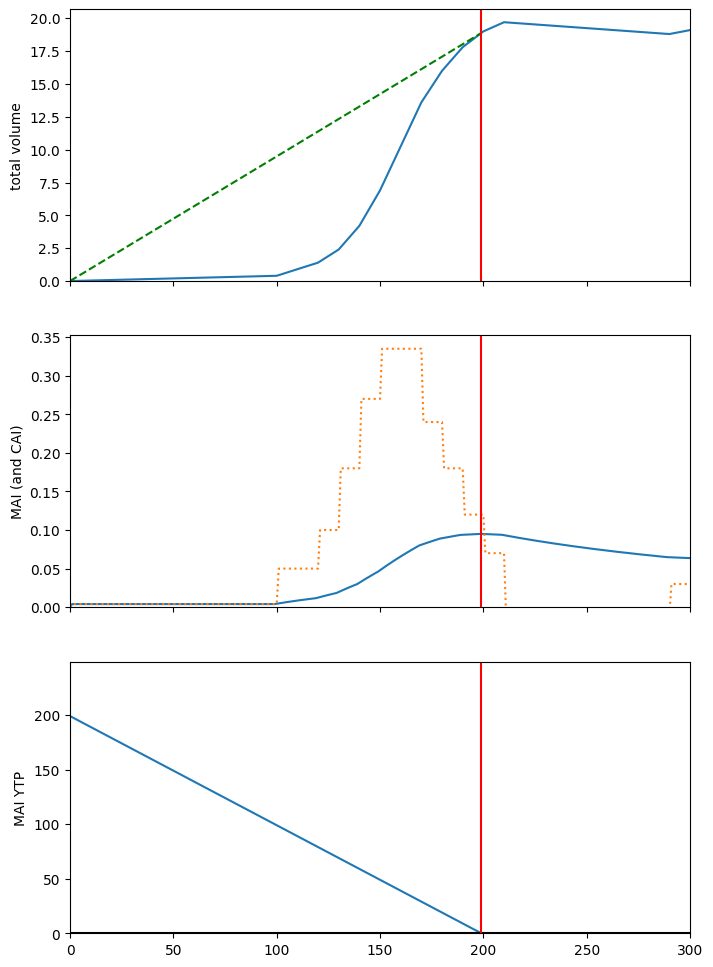

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12), sharex=True)

cvol = c
ccai = c.cai()
cmai = c.mai()
cmaiytp = c.mai().ytp()
x_cmai = cmaiytp.lookup(0) # optimal rotation age (i.e., culmination of MAI curve)
labels = 'total volume', 'MAI (and CAI)', 'MAI YTP'

ax[0].plot(*zip(*c.points()))
ax[0].plot([0, x_cmai], [0., cvol[x_cmai]], linestyle='--', color='green')

ax[1].plot(*zip(*c.mai().points()))
ax[1].plot(*zip(*c.cai().points()), linestyle=':')

ax[2].plot(*zip(*c.mai().ytp().points()))
ax[2].axhline(0, color='black')

for i in range(len(ax)):
    ax[i].set_ylabel(labels[i])
    ax[i].set_ylim(0, None)
    ax[i].axvline(x_cmai, color='red')
plt.xlim(0, 300)

## ACTIONS section

The ACTIONS section defines actions that can be applied in the model (e.g., harvesting, planting, thinning, fertilization, etc). 

In [36]:
with open(woodstock_model_files_act_path, 'w') as file:
    print('ACTIONS', file=file)
    print('*ACTION harvest Y', file=file)
    print('*OPERABLE harvest', file=file)
    print('? 1 ? ? ? ? _AGE >= 90 AND _AGE <= 600', file=file)

## TRANSITIONS section

The TRANSITIONS section defines transitions (i.e., transition to a new development type and age class induced by applying a specific action to a specific combination of development type and age class). If there were no transitions in a forest estate model, it would simply be aging (i.e., growing) the forest forward from time step 1 through to time step N.

In [37]:
with open(woodstock_model_files_trn_path, 'w') as file:
    acode = 'harvest'
    print('*CASE', acode, file=file)
    record_au = set()
    for au_id, au_row in stands.iterrows():
        if au_row.theme2 in record_au: continue
        if not au_row.theme1: continue
        au = au_row.theme2
        target_curve_id = au
        # primary_determinant = au_row.theme5
        # smask = ' '.join(('?', '?', '?', '?', '?', str(target_curve_id)))
        # tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '?'))
        # smask_primary = ' '.join(('?', '?' , str(target_curve_id), '?', '?', '1'))
        # tmask_primary = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '0'))
        # smask_secondary = ' '.join(('?', '?' , str(target_curve_id), '?', '?', '0'))
        # tmask_secondary = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '0'))
        smask = ' '.join(('?', '1' , str(au), '?', '?', '?'))
        tmask = ' '.join(('?', '?' , '?', '?', str(target_curve_id), '2'))

        print('*SOURCE', smask, file=file)
        print('*TARGET', tmask, '100', file=file)

        record_au.add(au_row.theme2)